In [1]:
# -*- coding: utf-8 -*-
import re
import time
import datetime 
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 10,8

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [2]:
reward_table = [
    [ -250 , -15000, -405 , -15000],
    [-309 , -15000, -400 , 405  ],
    [-262 , -15000, -255 , 400  ],
    [-231 , -15000, -77  , 255  ],
    [-61  , -15000, 0    , 77   ],
    [0    , -15000, 0    , 0    ],
    [0    , -15000, -15000, 0    ],
    [-325 , 250  , -452 , -15000],
    [-270 , 309  , -325 , 452  ],
    [-200 , 262  , -190 , 325  ],
    [-125 , 231  , -10  , 190  ],
    [-2   , 61   , 0    , 10   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-192 , 325  , -390 , -15000],
    [-169 , 270  , -285 , -390 ],
    [-105 , 200  , -132 , 285  ],
    [-10  , 125  , -5   , 132  ],
    [0    , 2    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-117 , 192  , -350 , -15000],
    [-67  , 169  , -235 , 350  ],
    [-8   , 105  , -26  , 235  ],
    [0    , 10   , 0    , 26   ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-38  , 117  , -250 , -15000],
    [0    , 67   , -148 , 250  ],
    [0    , 8    , -3   , 148  ],
    [0    , 0    , 0    , 3    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [0    , 38   , -195 , -15000],
    [0    , 0    , -193 , 195  ],
    [0    , 0    , -5   , 193  ],
    [0    , 0    , 0    , 5    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , 0    , 0    ],
    [0    , 0    , -15000, 0    ],
    [-15000, 0    , -255 , -15000],
    [-15000, 0    , -190 , 255  ],
    [-15000, 0    , -8   , 190  ],
    [-15000, 0    , 0    , 8   ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , 0    , 0    ],
    [-15000, 0    , -15000, 0    ]
]; 

In [3]:
def softmax(f):
    f = f - np.max(f)
    p = np.exp(f) / np.sum(np.exp(f))
    return p

In [4]:
softmax_reward_table = np.apply_along_axis(softmax, 1, reward_table)

In [5]:
def action_is_allowed(learner, state, action):

    if (action == 0 and not(state > learner.num_states - learner.servo_num_states - 1)):
        return True
    elif (action == 1 and not(state < learner.servo_num_states)):
        return True
    elif (action == 2 and not((state%learner.servo_num_states) == (learner.servo_num_states-1))):
        return True
    elif (action == 3 and not(state%learner.servo_num_states==0)):
        return True
    else:
        return False

In [153]:
class QLearner(object):
    def __init__(self, 
                 servo_num_states, 
                 num_actions, 
                 alpha, 
                 gamma, 
                 random_action_rate,
                 random_action_decay_rate, 
                 warm_up_period, 
                 action_penalty,
                 negative_reward_coef,
                 interest_zone_reward_coef,
                 initial_state):
        
        self.servo_num_states = servo_num_states
        self.num_states = servo_num_states**2
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.random_action_rate = random_action_rate
        self.random_action_decay_rate = random_action_decay_rate
        self.warm_up_period = warm_up_period
        self.state = initial_state
        self.action = 0
        self.action_penalty = action_penalty
        #self.qtable = np.random.uniform(low=-1, high=1, size=(self.num_states, self.num_actions))
        self.qtable = np.zeros((self.num_states, self.num_actions))
        self.num_iteration = 0
        self.last_reward = 0
        self.negative_reward_coef = negative_reward_coef
        self.interest_zone_reward_coef = interest_zone_reward_coef
        self.scaling_factor = 1
        
    def set_initial_state(self, action):
        """
        @summary: Sets the initial state and returns an action
        @param state: The initial state
        @returns: The selected action
        """
        self.state = int(self.num_states/2)
        self.action = action #self.qtable[state].argsort()[-1]
        
    def get_next_state(self):
        
        next_state = None
        
        if (self.action == 0 and action_is_allowed(self, self.state, self.action)): 
            next_state = self.state + self.servo_num_states
        elif (self.action == 1 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - self.servo_num_states
        elif (self.action == 2 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state + 1
        elif (self.action == 3 and action_is_allowed(self, self.state, self.action)):
            next_state = self.state - 1 
        else:
            next_state = self.state;
            
        return next_state
        
    def move(self, state_prime, reward):
        """
        @summary: Moves to the given state with given reward and returns action
        @param state_prime: The new state
        @param reward: The reward
        @returns: The selected action
        """
        alpha = self.alpha
        gamma = self.gamma
        state = self.state
        action = self.action
        qtable = self.qtable
        action_prime = -1
        
#         if self.state == state_prime: 

#             while not self.action_is_allowed(action_prime):
#                 action_prime = np.random.randint(0, self.num_actions)
            
#             self.action = action_prime
            
        if False:
            print 'yo'
            
        else: 
            
            choose_random_action = (1 - self.random_action_rate) <= np.random.uniform(0, 1)

            if choose_random_action:
#                 while not(action_is_allowed(self, state_prime, action_prime)): 
                action_prime = np.random.randint(0, self.num_actions)
            else:
                ordered_action_list = self.qtable[state_prime].argsort()
                best_choice_index = -1
#                 while not(action_is_allowed(self, state_prime, action_prime)):
                action_prime = ordered_action_list[best_choice_index]
#                     best_choice_index -= 1

            if self.num_iteration > self.warm_up_period: # warm up period is over
                self.random_action_rate *= self.random_action_decay_rate
                    
            
            if reward < 0 and np.abs(reward) < 15000:
                reward = reward * self.negative_reward_coef
            
            if self.num_iteration % 50 == 0:
                qtable *= self.scaling_factor
                
            
            qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * qtable[state_prime, action_prime] - qtable[state, action])

            self.state = state_prime
            self.action = action_prime    
            self.qtable = qtable

In [148]:
def get_final_reward(learner, reward_table, training_iteration):
    
    reward_list = []
    
    for iteration_step in xrange(training_iteration):

        reward = reward_table[learner.state][learner.action] - learner.action_penalty

        if learner.state % learner.servo_num_states > 2 and learner.state < 30:
            reward = reward * learner.interest_zone_reward_coef if reward > 0 else reward
            
        if reward < 0:
            reward *= learner.negative_reward_coef
        
        next_state = learner.get_next_state()

        learner.move(next_state, reward)
        
        learner.num_iteration += 1 

        reward_list.append(np.mean(reward))
        
    return np.mean(reward_list)
    
    

In [222]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials
import datetime

best_score = np.inf

def score(params):
    
    global best_score    
    
    num_iteration = 2
    
    loss_vector = []
    
    for i in xrange(num_iteration):
    
        learner = QLearner(servo_num_states = 7,
                           num_actions=4,
                           alpha=float(params['alpha']),
                           gamma=float(params['gamma']),
                           random_action_rate=float(params['random_action_rate']),
                           random_action_decay_rate=float(params['random_action_decay_rate']),
                           warm_up_period=int(params['warm_up_period']),
                           action_penalty=50,
                           negative_reward_coef=1, #float(params['negative_reward_coef']),
                           interest_zone_reward_coef =1, #float(params['interest_zone_reward_coef']),
                           initial_state=24)#int(params['initial_state'])) #float(params['action_penalty']))
        #learner.set_initial_state(action=0)

        temp_loss = - get_final_reward(learner, reward_table, training_iteration=50000) # negative because we want to minimize loss
        loss_vector.append(temp_loss)
        
    loss = np.mean(loss_vector)
    
    if loss < best_score: 
        print "Searching...", 
        print "New best score: {0:.6f}".format(-loss), 
        print params 
        print datetime.datetime.now().time()
        print
        best_score = loss

    return {'loss': loss, 'status': STATUS_OK}
    
def optimize(trials):
        
    space = {
             'alpha': hp.uniform('alpha', 0.1, 1),
             'gamma': hp.uniform('gamma', 0.1, 1),
             'random_action_rate': hp.uniform('random_action_rate', 0.1,1), 
             'random_action_decay_rate': hp.uniform('random_action_decay_rate', 0.1, 1),
             'warm_up_period': hp.quniform('warm_up_period', 0, 50, 1)
#              'initial_state': hp.quniform('initial_state', 0, 47, 1)
#              'negative_reward_coef': hp.uniform('negative_reward_coef', 1, 1.5),
#              'interest_zone_reward_coef': hp.uniform('interest_zone_reward_coef', 1, 1.5)
            }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=500)

    print '------------------------' 
    print "Done."
    print "Best parameter setting:", best
    return best

In [223]:
%%time

#Trials object where the history of search will be stored
trials = Trials()

best_params = optimize(trials)

Searching... New best score: -54.033230 {'random_action_rate': 0.5932182468439383, 'warm_up_period': 18.0, 'gamma': 0.9076247919054737, 'random_action_decay_rate': 0.9627554365415967, 'alpha': 0.27031053808280464}
17:24:04.566655

Searching... New best score: -53.742400 {'random_action_rate': 0.2942254782758122, 'warm_up_period': 31.0, 'gamma': 0.19769316709691204, 'random_action_decay_rate': 0.7866836786669388, 'alpha': 0.2647812653804158}
17:24:11.853936

Searching... New best score: -52.542280 {'random_action_rate': 0.7009944029877727, 'warm_up_period': 17.0, 'gamma': 0.7280447375987511, 'random_action_decay_rate': 0.6288218749572573, 'alpha': 0.5732708531604611}
17:24:22.759437

Searching... New best score: -51.488520 {'random_action_rate': 0.6971195639784412, 'warm_up_period': 35.0, 'gamma': 0.4922456690325856, 'random_action_decay_rate': 0.884151244614023, 'alpha': 0.42342305392704693}
17:24:26.350238

Searching... New best score: -36.359900 {'random_action_rate': 0.9943732853137

KeyboardInterrupt: 

In [276]:
1600*.25

400.0

In [277]:
400/60.

6.666666666666667

100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


3
4
11
18
17
10
3
4
11
18
17
10
3
4
11
18
17
10
3
4
11
18
17
10
3
4
11
18
17

Reward per action:  -176.51034606


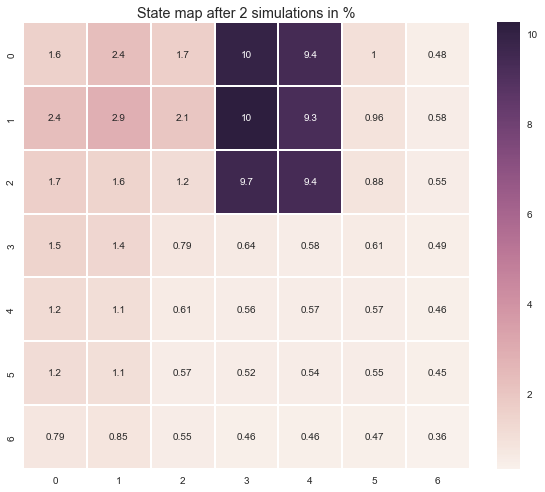

In [385]:
def crawling_simulation(params, reward_table, training_iteration = 5000, num_simulation = 2):
    
    state_vector = np.zeros(49)
    action_vector = np.zeros(4)
    reward_vector = []
    
    for simulation in tqdm(xrange(num_simulation)):
        
        temp_reward = []
        
#         learner = QLearner(servo_num_states = 7,
#                            num_actions=4,
#                            alpha=float(params['alpha']),
#                            gamma=float(params['gamma']),
#                            random_action_rate=float(params['random_action_rate']),
#                            random_action_decay_rate=float(params['random_action_decay_rate']),
#                            warm_up_period=int(params['warm_up_period']),
#                            action_penalty=50,
#                            negative_reward_coef= flaot,
#                            interest_zone_reward_coef = 1.1,
#                            initial_state=int(params['initial_state'])) #float(params['action_penalty']))
        
        learner = QLearner(servo_num_states = 7,
                   num_actions=4,
                   alpha=float(params['alpha']),
                   gamma=float(params['gamma']),
                   random_action_rate=float(params['random_action_rate']),
                   random_action_decay_rate=float(params['random_action_decay_rate']),
                   warm_up_period=int(params['warm_up_period']),
                   action_penalty=50,
                   negative_reward_coef=1.,#float(params['negative_reward_coef']),
                   interest_zone_reward_coef = 1.32, #float(params['interest_zone_reward_coef']),
                   initial_state=24)#int(params['initial_state'])) #float(params['action_penalty']))

#         learner.set_initial_state(action=0)

        stop = False
    
        for iteration_step in xrange(training_iteration):
            
#             if learner.num_iteration == 1000:
#                 print learner.qtable[0]

            
            state_vector[learner.state] += 1
            action_vector[learner.action] += 1 
            
#             if iteration_step - 1 == learner.warm_up_period and simulation == 0:
#                 #print learner.state, learner.action, learner.qtable[learner.state]
#                 print learner.qtable
                
#             if iteration_step == 9980  and simulation == 0:
#                 #print learner.state, learner.action, learner.qtable[learner.state]
#                 print learner.qtable
                
#             if iteration_step > 3000 and iteration_step < 3020:
#                 print learner.state
    
            if iteration_step > training_iteration-30 and simulation == num_simulation-1:
                print learner.state 
#                 print learner.qtable
 
                            

                
            reward = reward_table[learner.state][learner.action]*np.random.uniform(.5,1.5) - learner.action_penalty
            
            if learner.state % learner.servo_num_states > 2 and learner.state < 30:
                reward = reward * learner.interest_zone_reward_coef if reward > 0 else reward * learner.negative_reward_coef
            
#             if reward < 0:
#                 reward *= learner.negative_reward_coef
            
            temp_reward.append(reward)
            
            next_state = learner.get_next_state()
            
#             dup = False
#             if next_state == learner.state:
#                 dup = True
#                 print iteration_step, next_state, learner.action, reward, 

            learner.move(next_state, reward)
            learner.num_iteration += 1 
#             if dup:
#                 print next_state
#                 print learner.qtable[next_state]
#                 print '----'
        reward_vector.append(np.mean(temp_reward))
        
    normalize_state_vector = (state_vector/np.sum(state_vector)) * 100.
    state_map = pd.DataFrame(normalize_state_vector.reshape(learner.servo_num_states, -1))
    sns.heatmap(state_map, linewidths=1, annot=True)
    plt.title('State map after {} simulations in %'.format(num_simulation))
    
    normalize_action_vector = (action_vector/np.sum(action_vector)) * 100.
    
    #print len(reward_vector)
    print "\nReward per action: ",np.mean(reward_vector)
    #print normalize_action_vector
    
    return learner


# best_params = {'alpha': 0.40619963352672517, 
#                'random_action_decay_rate': 0.8189717113594237, 
#                'gamma': 0.9760578814233064, 
#                'warm_up_period': 341.0}
# best_params = {'warm_up_period': 363.0, 
#                'negative_reward_coef': 1.657585408801534, 
#                'gamma': 0.9744212450698116, 
#                'random_action_decay_rate': 0.7206861521993938, 
#                'alpha': 0.7199800066939188}
# best_params = {'alpha': 0.9613645426995369, 
#                'random_action_decay_rate': 0.6862739427670339, 
#                'gamma': 0.9680926035857673, 
#                'warm_up_period': 65.0}


# best_params = {'warm_up_period': 5.0, 
#                'random_action_decay_rate': 0.5541460471345169, 
#                'alpha': 0.7506149332042706, 
#                'initial_state': 12.0, 
#                'random_action_rate': 0.8708637956794232, 
#                'gamma': 0.9791556652375034} 


best_params = {'random_action_rate': 0.3019595582543259, 'warm_up_period': 46.0, 'gamma': 0.9758541654964458, 'random_action_decay_rate': 0.4885980315144308, 'alpha': 0.7155591636155634}
learner = crawling_simulation(best_params, reward_table)

In [318]:
np.random.uniform(.7,1.3)

0.8384998419585881